In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("./Restaurant_Reviews.tsv", delimiter='\t', quoting=3)
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [2]:
df.shape

(1000, 2)

In [3]:
df['Liked'].value_counts()

0    500
1    500
Name: Liked, dtype: int64

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

stemm = PorterStemmer()

In [5]:
corpus = []
for i in range(0,1000):

  # Cleaning special character from the reviews
    review = re.sub(pattern='[^a-zA-Z]',repl=' ', string=df['Review'][i])
    
    #to lowercase
    review = review.lower()
    
    #Tokenization
    review_words = review.split()
    
    #remove stopwords
    review_words = [word for word in review_words if not word in set(stopwords.words('english'))]
    
    # Stemming the words
    review= [stemm.stem(word) for word in review_words]

  # Joining the stemmed words
    review = ' '.join(review)

  # Creating a corpus
    corpus.append(review)

In [6]:
corpus[:10]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price',
 'get angri want damn pho',
 'honeslti tast fresh',
 'potato like rubber could tell made ahead time kept warmer',
 'fri great',
 'great touch']

In [7]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features= 1500)
X = cv.fit_transform(corpus).toarray()
Y = y = df.iloc[:, 1].values

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0, test_size= 0.2)

In [9]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, Y_train)

MultinomialNB()

In [10]:
Y_predicted = classifier.predict(X_test)

In [11]:
from sklearn.metrics import classification_report

report = classification_report(Y_predicted, Y_test)

print(report)

              precision    recall  f1-score   support

           0       0.74      0.77      0.75        94
           1       0.79      0.76      0.78       106

    accuracy                           0.77       200
   macro avg       0.76      0.77      0.76       200
weighted avg       0.77      0.77      0.77       200



In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_predicted, Y_test))

0.765


In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_predicted, Y_test)

Text(69.0, 0.5, 'Actual values')

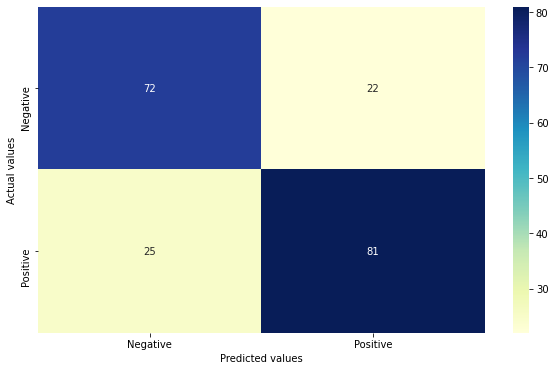

In [14]:
# Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10,6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

In [15]:
#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'naive_bayes': {
        'model': MultinomialNB(),
        'params' : {
            'alpha': [0.1,1.1,0.1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [100,200,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='saga',multi_class='ovr'),
        'params': {
            'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]
        }
    }
}
   

In [16]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df1 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df1

C:\Users\sarth\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sarth\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sarth\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sarth\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sarth\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

,model,best_score,best_params
0,naive_bayes,0.7600,{'alpha': 1.1}
1,random_forest,0.7525,{'n_estimators': 200}
2,logistic_regression,0.7625,{'C': 100.0}


In [17]:
best_estimators

{'naive_bayes': MultinomialNB(alpha=1.1),
 'random_forest': RandomForestClassifier(n_estimators=200),
 'logistic_regression': LogisticRegression(C=100.0, multi_class='ovr', solver='saga')}

In [18]:
best_estimators['naive_bayes'].score(X_test, Y_test)

0.765

In [19]:
best_estimators['random_forest'].score(X_test, Y_test)

0.7

In [20]:
best_estimators['logistic_regression'].score(X_test, Y_test)

0.725

In [21]:
def predict_sentiment(sample_review):
    sample_review = re.sub(pattern='[^a-zA-Z]',repl=' ', string = sample_review)
    sample_review = sample_review.lower()
    sample_review_words = sample_review.split()
    sample_review_words = [word for word in sample_review_words if not word in set(stopwords.words('english'))]
    ps = PorterStemmer()
    final_review = [ps.stem(word) for word in sample_review_words]
    final_review = ' '.join(final_review)

    temp = cv.transform([final_review]).toarray()
    return classifier.predict(temp)

In [22]:
# Predicting values
sample_review = 'The food is really good here.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a POSITIVE review.


In [23]:
# Predicting values
sample_review = 'Great food'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a POSITIVE review.


In [25]:
# Predicting values
sample_review = 'Bad presentation and unhealthy food'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a NEGATIVE review!


In [26]:
import pickle
with open('Restaurant_Review_model.pickle','wb') as f:
    pickle.dump(classifier,f)